## Regularized Linear Regression and Bias v.s. Variance
1. [读取数据](#读取数据)
2. [画出数字](#画出数字)
3. [构建模型(正则化的线性回归模型)](#bd)
4. [使用scipy.optimize优化算法训练](#训练模型)
4. [画出学习曲线](#画出学习曲线)
4. [多项式回归( Polynomial regression)](#pr)
4. [使用交叉验证集(cross validation set)选择λ](#cv)
3. [计算测试集误差](#计算测试集误差)

In [1]:
import numpy as np
import theano
import theano.tensor as T
import time
import scipy.io as sio
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, CuDNN 3007)
/home/lsr/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### 读取数据

In [2]:
data = sio.loadmat('ex5data1.mat')
X = data['X'].astype('float32') # (12 ,1)
y = data['y'].astype('float32') # (12 ,1)
Xval = data['Xval'].astype('float32')  # (21 ,1)
yval = data['yval'].astype('float32') # (21 ,1)
Xtest = data['Xtest'].astype('float32') # (21 ,1)
ytest = data['ytest'].astype('float32') # (21 ,1)

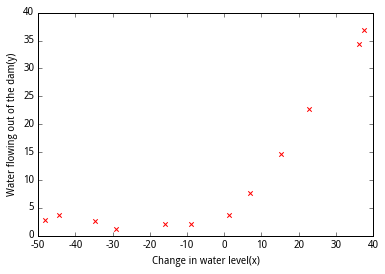

In [3]:
# plot training data
plt.scatter(X, y, c='red', marker=u'x')
plt.xlim(-50 ,40)
plt.ylim(0 ,40)
plt.xlabel('Change in water level(x)')
plt.ylabel('Water flowing out of the dam(y)')

### 构建模型(正则化的线性回归模型)<span id='bd'/>

In [4]:
class Model(object):

    def __init__(self, input, target):
        self.X = input
        self.Y = target
        self.X_theano = theano.shared(self.X, name='x') # (m ,n)
        self.Y_theano = theano.shared(self.Y, name='y') # (m, 1)
        self.thetaAll = theano.shared(np.ones(self.X.shape[1] + 1), name='theta') # (n+1, )
        theta = T.reshape(self.thetaAll[0 : self.X_theano.shape[1]], [self.X_theano.shape[1], 1]) # (n, 1)
        b = self.thetaAll[self.X_theano.shape[1] :] # (1, )
        lambdaVal = T.scalar(name='lambda')

        pred = T.dot(self.X_theano, theta) + b # (m, 1)

        cost = T.mean((pred - self.Y_theano) ** 2) / 2 + T.sum(theta ** 2) * lambdaVal / (2 * self.X_theano.shape[0])
        gradTheta = T.dot(self.X_theano.T, pred - self.Y_theano) / self.X_theano.shape[0] + theta * lambdaVal /  self.X_theano.shape[0] # (n, 1)
        gradB = T.mean(pred - self.Y_theano) # (1, )
        gradAll = T.concatenate([T.flatten(gradTheta), T.flatten(gradB)]) # (n+1, ) 
        gradAll_auto = T.grad(cost, self.thetaAll) # (n+1, )

        self.calcLoss = theano.function([lambdaVal], cost)
        self.calcGrad = theano.function([lambdaVal], gradAll)
        self.calcPred = theano.function([], pred)

In [5]:
# initial model
model = Model(X, y) 
model.calcLoss(0)

array(303.95151862212845)

### 训练模型

In [6]:
# 计算指定theta时的cost,使用optimize的函数时,传入的待优化参数是一个一维向量,所以要转成二维列向量,并且使用fmin时还需要转成float32类型
def computeCost(theta_value, theta, lambdaVal):
    theta.set_value(theta_value.astype('float32'))
    return model.calcLoss(lambdaVal)

# 计算指定theta时的梯度
def train_fn_grad(theta_value, theta, lambdaVal):
    theta.set_value(theta_value.astype('float32'))
    return model.calcGrad(lambdaVal).flatten() # 梯度也要转为一维向量

def trainModel(X, Y, lambdaVal):
    model.X_theano.set_value(X)
    model.Y_theano.set_value(Y)

    start_time = time.time()
    x0 = np.zeros(X.shape[1] + 1)
    args = (model.thetaAll, lambdaVal) # lambdaVal
    maxiter = 200
    # 使用共轭梯度法优化
    thetaV = [] # 存储每一次迭代后的结果
    thetaValue = optimize.fmin_cg( # or fmin_bfgs
        f=computeCost,
        x0=x0,
        fprime=train_fn_grad,
        args=args,
        disp=1,
        maxiter=maxiter
    )
    model.thetaAll.set_value(thetaValue)
    end_time = time.time()
    print 'training cost %.2f s' % (end_time - start_time)

In [7]:
# train
trainModel(X, y, 0)

         Current function value: 22.373906
         Iterations: 2
         Function evaluations: 47
         Gradient evaluations: 35
training cost 0.02 s


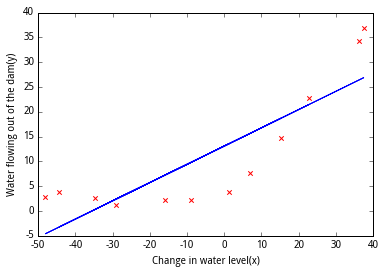

In [8]:
# Plot fit over the data
plt.scatter(X, y, c='red', marker=u'x')
plt.xlim(-50 ,40)
plt.ylim(-5 ,40)
plt.xlabel('Change in water level(x)')
plt.ylabel('Water flowing out of the dam(y)')
plt.plot(X, model.calcPred())

### 画出学习曲线

In [9]:
def learningCurve(X, y, Xval, yval, lambdaVal):
    trainingCost = []
    validCost = []
    for i in np.arange(X.shape[0]) + 1:
        trainModel(X[0 : i, :], y[0 : i, :], lambdaVal)
        trainingCost.append(model.calcLoss(lambdaVal))
        model.X_theano.set_value(Xval)
        model.Y_theano.set_value(yval)
        validCost.append(model.calcLoss(lambdaVal))
    return trainingCost, validCost

In [10]:
trainingCost, validCost = learningCurve(X, y, Xval, yval, 1)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 35
         Gradient evaluations: 35
training cost 0.01 s
Optimization terminated successfully.
         Current function value: 0.001307
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 8
training cost 0.00 s
         Current function value: 3.335017
         Iterations: 6
         Function evaluations: 52
         Gradient evaluations: 40
training cost 0.02 s
         Current function value: 2.881847
         Iterations: 9
         Function evaluations: 63
         Gradient evaluations: 51
training cost 0.02 s
Optimization terminated successfully.
         Current function value: 13.174273
         Iterations: 20
         Function evaluations: 34
         Gradient evaluations: 34
training cost 0.01 s
         Current function value: 19.461396
         Iterations: 18
         Function evaluations: 102
         Gradi

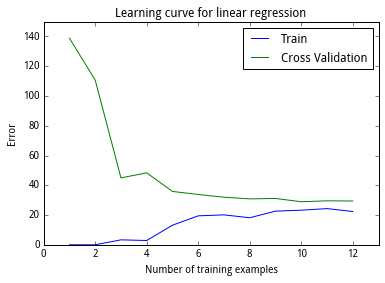

In [11]:
plt.plot(np.arange(X.shape[0]) + 1, trainingCost)
plt.plot(np.arange(X.shape[0]) + 1, validCost)
plt.xlim(0, 13)
plt.ylim(0, 150)
plt.title('Learning curve for linear regression')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend(['Train', 'Cross Validation'])

### 多项式回归( Polynomial regression)<span id='pr'/>

In [12]:
def polyFeatures(X, p):
    X_ploy = np.zeros([X.shape[0], p])
    for i in range(p):
        X_ploy[:, i] = X[:,0] ** (i + 1)
    return X_ploy.astype('float32')

def featureNormalize(x): # 特征尺度变换
    mu = x.mean(0)
    #sigma = x.std(0) # 估计的是总体标注差,除以的是m, matlab是m - 1
    sigma = np.sqrt(((x - mu) ** 2).sum(0) / (len(x) - 1)) # 样本标准差
    x_norm = (x - mu) / sigma
    return x_norm, mu, sigma

In [13]:
# feature map and normalize
p = 8
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)

X_poly_test =  polyFeatures(Xtest, p)
X_poly_test = (X_poly_test - mu) / sigma

X_poly_val =  polyFeatures(Xval, p)
X_poly_val = (X_poly_val - mu) / sigma

In [14]:
trainModel(X_poly, y, 0)

         Current function value: 3.469132
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
training cost 0.00 s


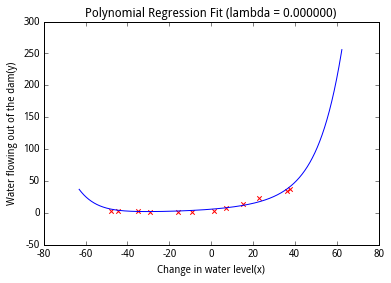

In [15]:
# Plot fit over the data
plt.scatter(X, y, c='red', marker=u'x')
#plt.xlim(-50 ,40)
#plt.ylim(-100 ,40)
plt.xlabel('Change in water level(x)')
plt.ylabel('Water flowing out of the dam(y)')
plt.title('Polynomial Regression Fit (lambda = %f)' % 0.0)

xval = np.arange(np.min(X)-15, np.max(X)+25, 0.05)
xval.shape = -1, 1
xval_poly =  polyFeatures(xval, p)
xval_poly = (xval_poly - mu) / sigma
model.X_theano.set_value(xval_poly)
plt.plot(xval, model.calcPred())

In [16]:
trainingCost, validCost = learningCurve(X_poly, y, X_poly_val, yval, 0)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
training cost 0.00 s
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
training cost 0.00 s
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 21
         Gradient evaluations: 21
training cost 0.01 s
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 61
         Function evaluations: 117
         Gradient evaluations: 117
training cost 0.06 s
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 145
         Function evaluations: 250
         Gradient evaluations: 250
training cost 0.11 s
         Current function value: 0.0

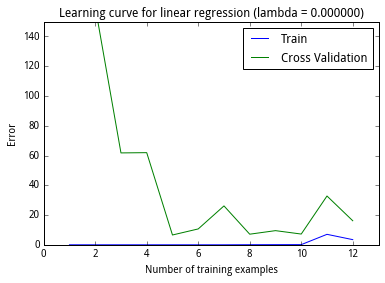

In [17]:
plt.plot(np.arange(X.shape[0]) + 1, trainingCost)
plt.plot(np.arange(X.shape[0]) + 1, validCost)
plt.xlim(0, 13)
plt.ylim(0, 150)
plt.title('Learning curve for linear regression (lambda = %f)' % 0.0)
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend(['Train', 'Cross Validation'])

###  使用交叉验证集(cross validation set)选择λ<span id='cv'/>

In [18]:
def validationCurve(lambda_vec,  X, y, Xval, yval):
    trainingCost = []
    validCost = []
    for lambda_val in lambda_vec:
        trainModel(X, y, lambda_val)
        trainingCost.append(model.calcLoss(lambda_val))
        model.X_theano.set_value(Xval)
        model.Y_theano.set_value(yval)
        validCost.append(model.calcLoss(lambda_val))
    return trainingCost, validCost

In [19]:
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
trainingCost, validCost = validationCurve(lambda_vec, X_poly, y, X_poly_val, yval)

         Current function value: 3.469132
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
training cost 0.00 s
         Current function value: 3.475268
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
training cost 0.00 s
         Current function value: 3.487537
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
training cost 0.00 s
         Current function value: 3.530467
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
training cost 0.00 s
         Current function value: 3.653005
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
training cost 0.00 s
         Current function value: 4.080489
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
training cost 0.00 s
         Current function value: 5.289963
         Iterations: 2
         Function

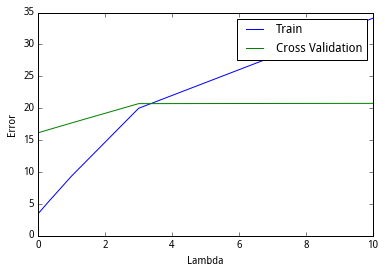

In [20]:
plt.plot(lambda_vec, trainingCost, lambda_vec, validCost)
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.legend(['Train', 'Cross Validation'])

### 计算测试集误差

In [21]:
bestLambda = 3 # 由上图交叉点位置得到
trainModel(X_poly, y, bestLambda)

         Current function value: 19.995011
         Iterations: 2
         Function evaluations: 16
         Gradient evaluations: 4
training cost 0.01 s


In [22]:
model.X_theano.set_value(X_poly_test)
model.Y_theano.set_value(ytest)
model.calcLoss(bestLambda)

array(19.1304519204491)